In [71]:
import pandas as pd
import numpy as np
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as mpl
from ast import literal_eval
from collections import Counter
from ipysigma import Sigma

# PSYOP Twitter Experiment

## Team Communities
 - 11th Cyber Battalion
 - G39

In [72]:

df = pd.concat(map(pd.read_csv, ["August_Twitter.csv","July_to_August_Twitter.csv", "May_to_July_Twitter.csv"]))

names = ['norm.author','meta.author_original','meta.tweet_type']
df2 = pd.DataFrame(df[names])
df3 = df2.dropna()

retweet = list()
for item in df3.iloc:
    if item['meta.tweet_type'] != "Original":
        retweet.append({'source': item['norm.author'], "original_poster":item['meta.author_original']})    
new_list = sorted(retweet, key=lambda x:x["source"])


retweet_df = pd.DataFrame(new_list)
retweet_sorted = pd.DataFrame(np.sort(retweet_df.values, axis = 1), columns = retweet_df.columns)
retweet_sorted["value"] = 1
retweet_sorted = retweet_sorted.groupby(["source","original_poster"], sort=False, as_index=False).sum()
new = retweet_sorted.sort_values(by="value", ascending=False)
new_filtered = new[new['value'] > 1]


G = nx.from_pandas_edgelist(new_filtered, source = "source", target="original_poster", edge_attr="value", create_using=nx.Graph())

degree = nx.degree_centrality(G)

## Percentage of Tweets

Most of the Tweets are retweets from another user. Meaning a user shared a posting from another user. The next highest is replies, where one user would mention another in a reply either from the original tweet or in the comments. Lastly, the original tweets are tweets that are initial tweets from a user.

In [73]:
get_percentage_of_post(df)

In [74]:
df.describe()
sorenson_df = df.dropna(subset=['meta.author_original', 'norm.author'])
df_filtered = sorenson_df[df['meta.author_original'] != 'NaN']
df_filtered = df_filtered[df_filtered['norm.author'] != 'NaN']

df_filtered['weight'] = df_filtered.groupby(['meta.author_original', 'norm.author'])['meta.author_original'].transform('size')

G = nx.from_pandas_edgelist(df_filtered, 'meta.author_original', 'norm.author',
                            create_using=nx.DiGraph(), edge_attr='weight')
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(list(nx.isolates(G)))
G.edges(data=True)
Sigma(G,node_size= G.degree)

/tmp/ipykernel_4756/370256690.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Sigma(nx.DiGraph with 13,910 nodes and 9,818 edges)

<BarContainer object of 13 artists>

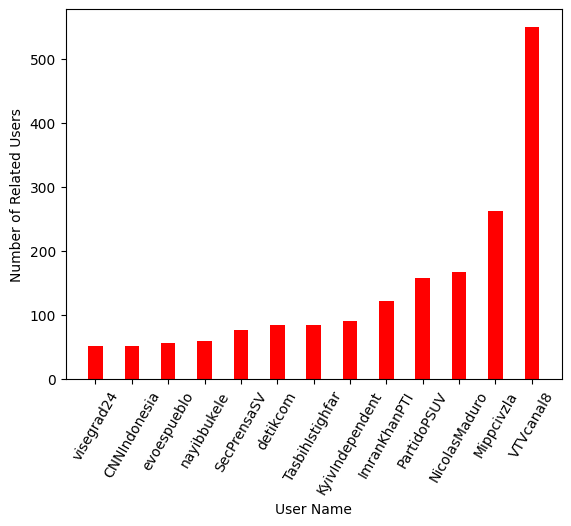

In [75]:
big_influence = dict(G.degree())
big_influence = {k:v for k,v in big_influence.items() if v > 50}
nodes = list([node for node,degree in dict(big_influence).items()])
degree = list([degree for node,degree in dict(big_influence).items()])
value = [v for k, v in sorted(big_influence.items(), key=lambda item: item[1])]
key = [k for k, v in sorted(big_influence.items(), key=lambda item: item[1])]
mpl.xticks(rotation=60)
mpl.xlabel("User Name")
mpl.ylabel("Number of Related Users")
mpl.bar(key, value, color ='red', width = 0.4)

In [76]:
df2=df[['meta.author_id','meta.hashtag']].dropna()
h = df2.dropna(subset = 'meta.hashtag')
h1 = h['meta.hashtag'].tolist()
h2 = []
for item in h1:

    try:
        h2.append(literal_eval(item))
    except:
        h2.append([item])
        continue

In [77]:
h['new_hashtag'] = h2

In [78]:

df2 = h
df2 = df2.explode('new_hashtag').reset_index()
df2.head(len(df2['meta.author_id'].unique()))
df2.rename(columns = {'meta.author_id' : 'MAID', 'meta.hashtag' : 'mh', 'new_hashtag' : 'newhash'}, inplace = True)

In [79]:
len(df2.MAID.unique())
df2.drop(columns=['mh'], inplace = True)

In [82]:
df3 = df2.groupby(['MAID'], as_index=False).agg({'newhash': '--'.join})
# HERE IS WHERE TO DISPLAY THE MOST USED HASHTAG
df3['newhash'].count()
df2.groupby(['newhash'])['MAID'].count().sort_values(ascending = False)
df2.groupby(['MAID'])['newhash'].count().sort_values(ascending = False)


MAID
1082902861648777216    88
1318998179979943937    85
218313101              53
1531604799715782657    42
1216550422191587328    37
                       ..
823170442076663809      1
1502779254634860546     1
1502688875403268098     1
825477847846379521      1
1578411848000577536     1
Name: newhash, Length: 3197, dtype: int64

In [81]:
def get_percentage_of_post(df):
    
    df_count = {"Reply": 0, "Retweet" : 0, "Original" : 0, "Quote": 0}
    #group_df = df.groupby("meta.tweet_type")
   # df = pd.DataFrame(group_df)
    #df.to_csv("csv.csv")
    for name in df.iloc:
        df_count[name['meta.tweet_type']] +=1
        
    new_df = pd.DataFrame.from_dict(df_count, orient='index', columns=['Count'])
    new_df = new_df.sort_values(by='Count', ascending=False)
    fig = go.Figure(data=[go.Bar(x=new_df.index, y=new_df['Count'])])
    
    fig.update_layout(
    title="Tweet Types",
    xaxis_title="Tweet Type",
    yaxis_title="Count",
    xaxis=dict(showline=True, showgrid=False),
    yaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    plot_bgcolor='white',
    )
 
    fig.show()